In [4]:
from text_processing.NGramCounter import NGramCounter
from text_processing.NGramVectorBuilder import NGramVectorBuilder
from data_module.models import Person, Examination, Description, ImageSeries
from data_module.models import Image as Retina_Image
from random import shuffle
import random, re, PIL, csv, cv2, os, time, sys
import numpy as np
from skimage.transform import resize
np.random.seed(7)
import h5py

In [29]:
class Data_preparer():
    def __init__(self):
        self.load_image_resolution()
    
    def samples_from_file(self, f):
            reader = csv.reader(f.readline().split('\n'), delimiter=',')
            for row in reader:
                train_samples = np.array(row[:-1],dtype='uint8')
                break

            reader = csv.reader(f.readline().split('\n'), delimiter=',')
            for row in reader:
                val_samples = np.array(row[:-1],dtype='uint8')
                break

            reader = csv.reader(f.readline().split('\n'), delimiter=',')
            for row in reader:
                test_samples = np.array(row[:-1],dtype='uint8')
                break
            f.close()
            return train_samples,val_samples,test_samples
    
    def load_image_resolution(self):
        width = 1388
        height = 1038
        
        self.img_size_2 = 100
        self.img_size_1 = int(self.img_size_2 * (height / width))

    def get_images_metadata(self, examinations):
        pairs = []
        for examin in examinations:
            sequences = ImageSeries.objects.filter(examination=examin)
            for i in range(len(sequences)):
                if sequences[i].name.endswith("after_registration"):
                    continue
                imgModels = Retina_Image.objects.filter(image_series=sequences[i])
                for j in range(len(imgModels)):
                    for k in range(len(imgModels)):
                        if j >= k:
                            continue
                                
                        number1 = int(re.search(r'\d+', imgModels[j].name).group())
                        number2 = int(re.search(r'\d+', imgModels[k].name).group())
                        result = number1 > number2
                        y_train = 1
                        if (result):
                            y_train = 0
                        pairs.append(
                            {'series': sequences[i].id, 'first': imgModels[k].id, 'second': imgModels[j].id,
                                'y_train': y_train, 'first_name': imgModels[k].name, 'second_name': imgModels[j].name})
                        pairs.append(
                            {'series': sequences[i].id, 'first': imgModels[j].id, 'second': imgModels[k].id,
                                'y_train': 1-y_train, 'first_name': imgModels[j].name, 'second_name': imgModels[k].name})
        shuffle(pairs)
        return pairs
                            

    def prepare_image(self,_id):
        img = Retina_Image.objects.get(id=_id)
        img = PIL.Image.open(img.image).convert('L')
        arr_img = self.preprocess_image(img)
        return arr_img 

    def standardization(self,image):
        return (image - np.mean(image)) / np.std(image)
    
    def to_float(self, image):
        func = np.vectorize(lambda x: x / 255.0)
        return func(image)
    
    def preprocess_image(self,image):
        image = np.array(image)
        image = self.standardization(image)
        image = resize(image, (self.img_size_1, self.img_size_2, 1))
        return image

    def create_dataset_and_store(self,hdf5_file, name, metadata):
        x_name = name+'_x'
        x_shape = (len(metadata), self.img_size_1, self.img_size_2,2)
        hdf5_file.create_dataset(x_name, x_shape, np.float32)
        
        y_name = name+'_y'
        y_shape = (len(metadata),1)
        hdf5_file.create_dataset(y_name, y_shape, np.int8)
        
        meta_name = name+'_metadata'
        meta_shape = (len(metadata),)
        hdf5_file.create_group(meta_name)
        self.cache = dict()
        for i in range(len(metadata)):
            meta_elem = metadata[i]

            #save X data
            id_img_1 = meta_elem['first']
            id_img_2 = meta_elem['second']
            
            prepared_img_1 = self.get_cached_image(id_img_1)
            prepared_img_2 = self.get_cached_image(id_img_2)
                
            x = np.dstack((prepared_img_1,prepared_img_2))
            hdf5_file[x_name][i, ...] = x[None]

            #save Y data
            hdf5_file[y_name][i, ...] = meta_elem['y_train']
            
            #save metadata
            gr = hdf5_file.create_group(meta_name+'/'+str(i))
            for k, v in meta_elem.items():
                    gr[k] = v
                
    def get_cached_image(self,id_img):
        if id_img not in self.cache:
            self.cache[id_img] = self.prepare_image(id_img)
        return self.cache[id_img]
                
                
    def store_all_data_in_h5py_file(self):
        
        f = open('splited_data.txt')
        train_samples, val_samples, test_samples = self.samples_from_file(f)

        train_metadata = self.get_images_metadata(train_samples)
        val_metadata = self.get_images_metadata(val_samples)
        test_metadata = self.get_images_metadata(test_samples)

        hdf5_path = './sd-size-100-do-pracy.hdf5'
        hdf5_file = h5py.File(hdf5_path, mode='w')
        
        try: 
            self.create_dataset_and_store(hdf5_file,'train_data',train_metadata)
            self.create_dataset_and_store(hdf5_file,'val_data',val_metadata)
            self.create_dataset_and_store(hdf5_file,'test_data',test_metadata)
            hdf5_file.close()
            print('success')

        except:
            print('fail')
            hdf5_file.close()
            os.remove(hdf5_path)
            raise
        


In [30]:
data_preparer = Data_preparer()
data_preparer.store_all_data_in_h5py_file()

C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


success


In [7]:
print(np.arange(1,20))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


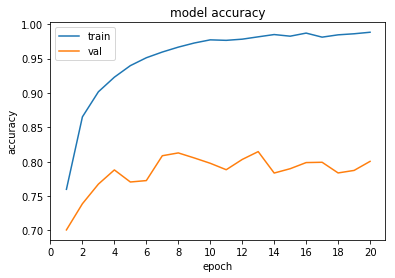

In [28]:
import matplotlib.pyplot as plt
x = np.arange(1,21,1)
y = np.load('sd50-bez-agm-32-32-32-1024-32-1.acc.npy')
y2 = np.load('sd50-bez-agm-32-32-32-1024-32-1.val_acc.npy')
fig, ax = plt.subplots()
ax.plot(x,y)
ax.plot(x,y2)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, 22, 2))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()